In [1]:
from covid_analysis import *

%matplotlib inline
sns.set(style="whitegrid")
FIGSIZE = [12, 8]

# México

In [2]:
estados_analisis = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]
estados = load_sinave()
mexico = {}
for ds_name, ds in estados.items():
    mexico[ds_name] = pd.DataFrame({'Mexico': ds.sum(axis=1)})

## Resumen

### Fecha de Actualización:

In [3]:
mexico['confirmados'].index[-1].strftime("%d-%m-%Y")

'12-04-2020'

### Confirmados

In [4]:
sum(mexico['confirmados'].iloc[-1])

4661

### Nuevos Confirmados

In [5]:
sum(mexico['daily_confirmados'].iloc[-1])

442

### Fallecimientos

In [6]:
sum(mexico['muertos'].iloc[-1])

296

### Nuevos Fallecimientos

In [7]:
sum(mexico['daily_muertos'].iloc[-1])

23

## Nacional

### México: Confirmados acumulados

dict_keys(['confirmados', 'daily_confirmados', 'probables', 'daily_probables', 'muertos', 'daily_muertos', 'descartados', 'daily_descartados'])


,Mexico
Date,
2020-03-30,5635
2020-03-31,6282
2020-04-01,7073
2020-04-02,7822
2020-04-03,8602
2020-04-04,9467
2020-04-05,10682
2020-04-06,11741
2020-04-07,15099


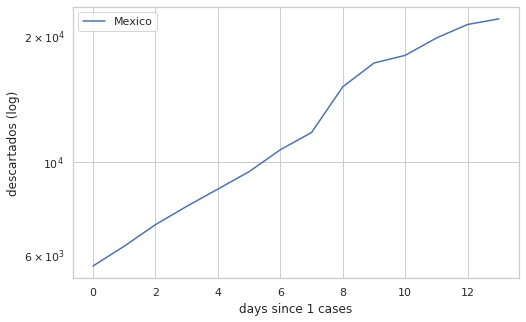

In [8]:
print(mexico.keys())
analysis(mexico, ["Mexico"], "descartados", log=True, smooth=False, since=1)

### México: Confirmados diarios

,Mexico
Date,
2020-03-31,121
2020-04-01,163
2020-04-02,132
2020-04-03,178
2020-04-04,202
2020-04-05,253
2020-04-06,296
2020-04-07,346
2020-04-08,396


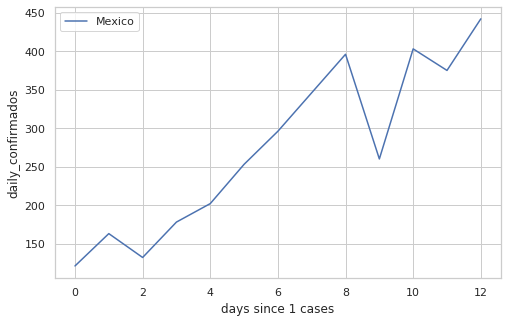

In [9]:
analysis(mexico, ["Mexico"], "daily_confirmados", since=1, smooth=False, log=False)

### México: Fallecimientos acumulados

,Mexico
Date,
2020-03-30,28
2020-03-31,29
2020-04-01,37
2020-04-02,50
2020-04-03,60
2020-04-04,79
2020-04-05,94
2020-04-06,125
2020-04-07,141


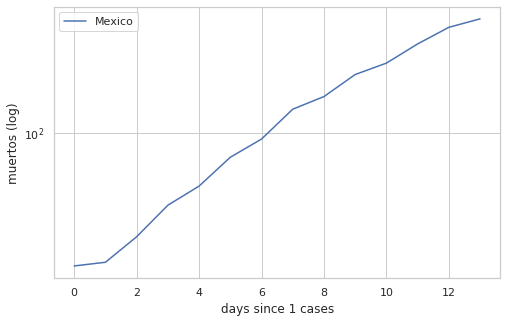

In [10]:
analysis(mexico, ["Mexico"], "muertos", since=1, smooth=False, log=True)

### México: Fallecimientos diarios

,Mexico
Date,
2020-03-31,1
2020-04-01,8
2020-04-02,13
2020-04-03,10
2020-04-04,19
2020-04-05,15
2020-04-06,31
2020-04-07,16
2020-04-08,33


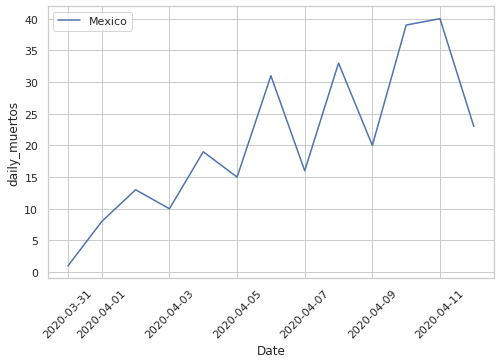

In [11]:
analysis(mexico, ["Mexico"], "daily_muertos", since=None, smooth=False, log=False)

### México: Pruebas reportadas por día, acumuladas

,Mexico
Date,
2020-03-30,9481
2020-03-31,11008
2020-04-01,12278
2020-04-02,13985
2020-04-03,15686
2020-04-04,17184
2020-04-05,18034
2020-04-06,20475
2020-04-07,25410


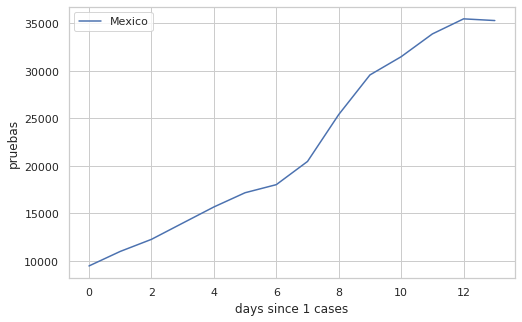

In [12]:
mexico['pruebas'] = mexico['confirmados'].add(mexico['probables']).add(mexico['descartados'])
analysis(mexico, ['Mexico'], 'pruebas', since=1, smooth=False, log=False)

In [13]:
mexico['descartados']

,Mexico
Date,
2020-03-30,5635
2020-03-31,6282
2020-04-01,7073
2020-04-02,7822
2020-04-03,8602
2020-04-04,9467
2020-04-05,10682
2020-04-06,11741
2020-04-07,15099


### México: Pruebas reportadas por día

,Mexico
Date,
2020-03-31,1527.0
2020-04-01,1270.0
2020-04-02,1707.0
2020-04-03,1701.0
2020-04-04,1498.0
2020-04-05,850.0
2020-04-06,2441.0
2020-04-07,4935.0
2020-04-08,4168.0


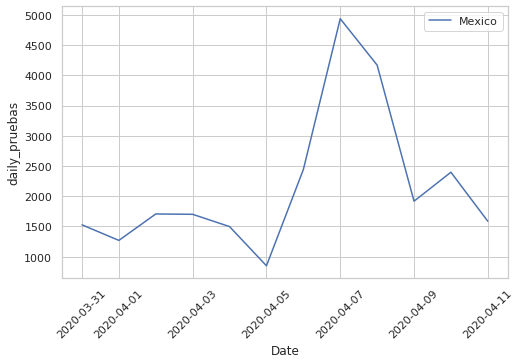

In [14]:
mexico['daily_pruebas'] = mexico['daily_confirmados'].add(mexico['daily_probables']).add(mexico['daily_descartados'])
analysis(mexico, ["Mexico"], "daily_pruebas", since=None, smooth=False, log=False)

### México: Proporción de confirmados del total de pruebas reportadas por día

,Mexico
Date,
2020-03-31,0.079240
2020-04-01,0.128346
2020-04-02,0.077329
2020-04-03,0.104644
2020-04-04,0.134846
2020-04-05,0.297647
2020-04-06,0.121262
2020-04-07,0.070111
2020-04-08,0.095010


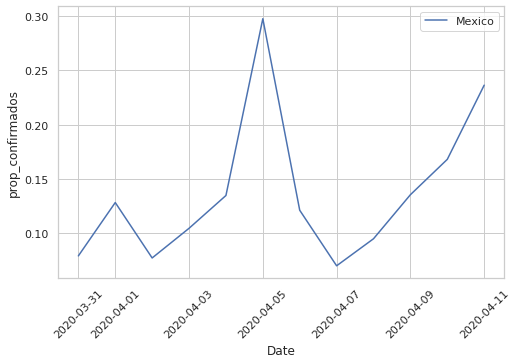

In [15]:
mexico['prop_confirmados'] = mexico['daily_confirmados'] / mexico['daily_pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados', smooth=False, log=False, since=None)

## Estados

### Estados: Confirmados acumulados

In [ ]:
analysis(estados, estados_analisis, "confirmados", since=1, log=True, smooth=False)

### Estados: Confirmados diarios

In [ ]:
analysis(estados, estados_analisis, "daily_confirmados", since=1, log=True, smooth=False)

### Estados: Fallecimmientos diarios 

In [ ]:
analysis(estados, estados_analisis, "daily_muertos", since=0, log=False, smooth=False)

### Estados: Trayectorias

In [ ]:
#trajectories(estados, estados_analisis, 'confirmados', since=2, window=3)

# Mundo

In [ ]:
analysis_countries = ["Mexico", "US", "Spain", "Italy", "Australia", "Korea, South"]
world = load_johns_hopkins()

## Mundo: Confirmados acumulados

In [ ]:
analysis(world, analysis_countries, "confirmed")

## Mundo: Confirmados diarios

In [ ]:
analysis(world, analysis_countries, "daily_confirmed", since=30)

## Mundo: Fallecimientos acumulados

In [ ]:
analysis(world, analysis_countries, "deaths", since=3)

## Mundo: Fallecimientos diarios

In [ ]:
analysis(world, analysis_countries, "daily_deaths", since=3)

## Mundo: Trayectorias de casos confirmados

In [ ]:
trajectories(world, analysis_countries, 'confirmed', since=50, window=7)

### Revisando

In [ ]:
#Aqui hay algunas diferencias con los datos de FT https://www.ft.com/coronavirus-latest 
#  sobre todo en el número de días, ¿es por el rolling average?
d = world['daily_deaths']['Spain']
d = get_values_since_first_geq(d, 3).reset_index(drop=True)
d = d.rolling(window=7).mean()
d.plot(logy=True)